<a href="https://colab.research.google.com/github/KrischML/cmi-kaggle-comp/blob/main/001_cmi_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

cmi_detect_behavior_with_sensor_data_path = kagglehub.competition_download('cmi-detect-behavior-with-sensor-data')

print('Data source import complete.')

100%|██████████| 178M/178M [00:03<00:00, 49.3MB/s]

Extracting files...


Data source import complete.


In [3]:
import os
import pandas as pd
import polars as pl
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [ ]:
for root, dirs, files in os.walk('/'):
    for file in files:
        if file.endswith('.csv'):
            print(os.path.join(root, file))

/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/train.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/test_demographics.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/test.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/train_demographics.csv
/root/.julia/packages/CSV/XLcqT/src/promotions.csv
/root/.julia/packages/CSV/XLcqT/test/out.test.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/test_multiple_missing.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/transposed_empty.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/test_utf8.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/test_file_issue_154.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/test_floats.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/FL_insurance_sample.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/test_no_header.csv
/root/.julia/packages/CSV/XLcqT/test/testfiles/groupmark_quote.csv
/ro

In [ ]:
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/train.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/test_demographics.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/test.csv
/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/train_demographics.csv

In [4]:
class CFG:

    ip_path: str = "/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/"

    random_state: int = 42

    LE = LabelEncoder()


print(CFG.ip_path)

/root/.cache/kagglehub/competitions/cmi-detect-behavior-with-sensor-data/


In [5]:
train_df = pd.read_csv(CFG.ip_path + "train.csv")
train_demographics_df  = pd.read_csv(CFG.ip_path + "train_demographics.csv")

test_df = pd.read_csv(CFG.ip_path + "test.csv")
test_demographics_df = pd.read_csv(CFG.ip_path + "test_demographics.csv")

In [6]:
# Merge demographic information into the main training dataframe
train_demo_df = train_df.merge(train_demographics_df, on="subject", how="left")



In [8]:
train_demo_df.head(2)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0


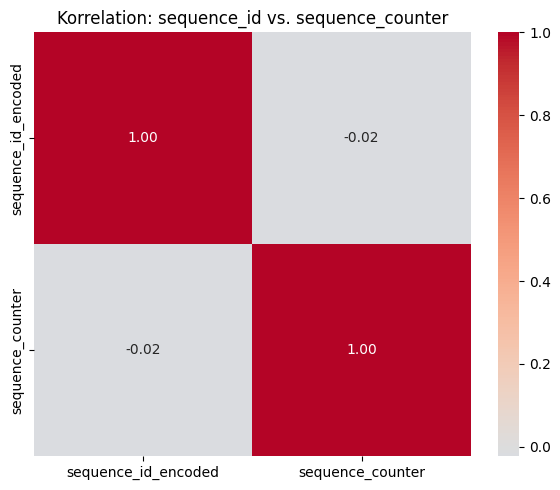

In [ ]:
# Annahme: train_df enthält die Spalten
df = train_demo_df.copy()

df['sequence_id_encoded'] = CFG.LE.fit_transform(df['sequence_id'])


corr_df = df[['sequence_id_encoded', 'sequence_counter']]

# Korrelation berechnen
corr = corr_df.corr()

# Heatmap plotten
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Korrelation: sequence_id vs. sequence_counter")
plt.tight_layout()
plt.show()


In [ ]:
train_demo_df['sequence_id'].unique()


array(['SEQ_000007', 'SEQ_000008', 'SEQ_000013', ..., 'SEQ_065522',
       'SEQ_065526', 'SEQ_065531'], dtype=object)

In [ ]:

acc_sencor_cols = [col for col in train_df.columns if any(s in col for s in ['acc_'])]
rot_sensor_cols = [col for col in train_df.columns if any(s in col for s in ['rot_'])]
thm_sensor_cols = [col for col in train_df.columns if any(s in col for s in ['thm_'])]
tof_sensor_cols = [col for col in train_df.columns if any(s in col for s in ['tof_'])]

thm_sensor_cols

['thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5']

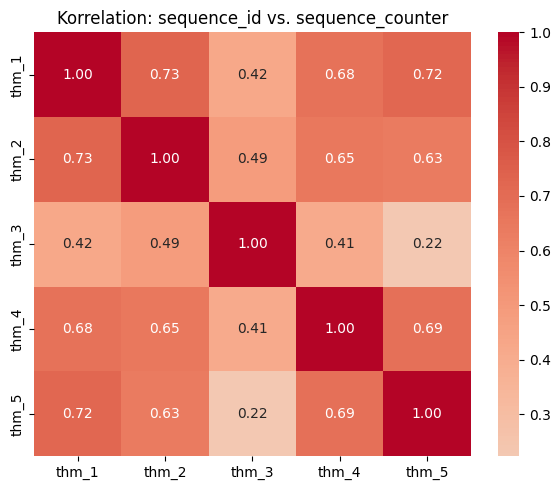

In [ ]:


corr_df = train_demo_df[thm_sensor_cols]
# Korrelation berechnen
corr = corr_df.corr()

# Heatmap plotten
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Korrelation: sequence_id vs. sequence_counter")
plt.tight_layout()
plt.show()

In [ ]:
all_sensor_cols = [col for col in train_df.columns if any(s in col for s in ['acc_', 'rot_', 'thm_', 'tof_'])]
all_sensor_cols

['acc_x',
 'acc_y',
 'acc_z',
 'rot_w',
 'rot_x',
 'rot_y',
 'rot_z',
 'thm_1',
 'thm_2',
 'thm_3',
 'thm_4',
 'thm_5',
 'tof_1_v0',
 'tof_1_v1',
 'tof_1_v2',
 'tof_1_v3',
 'tof_1_v4',
 'tof_1_v5',
 'tof_1_v6',
 'tof_1_v7',
 'tof_1_v8',
 'tof_1_v9',
 'tof_1_v10',
 'tof_1_v11',
 'tof_1_v12',
 'tof_1_v13',
 'tof_1_v14',
 'tof_1_v15',
 'tof_1_v16',
 'tof_1_v17',
 'tof_1_v18',
 'tof_1_v19',
 'tof_1_v20',
 'tof_1_v21',
 'tof_1_v22',
 'tof_1_v23',
 'tof_1_v24',
 'tof_1_v25',
 'tof_1_v26',
 'tof_1_v27',
 'tof_1_v28',
 'tof_1_v29',
 'tof_1_v30',
 'tof_1_v31',
 'tof_1_v32',
 'tof_1_v33',
 'tof_1_v34',
 'tof_1_v35',
 'tof_1_v36',
 'tof_1_v37',
 'tof_1_v38',
 'tof_1_v39',
 'tof_1_v40',
 'tof_1_v41',
 'tof_1_v42',
 'tof_1_v43',
 'tof_1_v44',
 'tof_1_v45',
 'tof_1_v46',
 'tof_1_v47',
 'tof_1_v48',
 'tof_1_v49',
 'tof_1_v50',
 'tof_1_v51',
 'tof_1_v52',
 'tof_1_v53',
 'tof_1_v54',
 'tof_1_v55',
 'tof_1_v56',
 'tof_1_v57',
 'tof_1_v58',
 'tof_1_v59',
 'tof_1_v60',
 'tof_1_v61',
 'tof_1_v62',
 'tof_1_

In [9]:
train_demo_df.head(2)

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v61,tof_5_v62,tof_5_v63,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,0,12,1,1,163.0,52,24.0


In [ ]:
cat_columns = [col for col in train_demo_df.columns if train_demo_df[col].dtype == 'object']
cat_columns

['row_id',
 'sequence_type',
 'sequence_id',
 'subject',
 'orientation',
 'behavior',
 'phase',
 'gesture']

In [ ]:
train_demo_df['thm_5'].isnull().sort_values(ascending=False)

,thm_5
426294,True
357874,True
460823,True
460824,True
460825,True
...,...
196833,False
196832,False
196831,False
196830,False


In [ ]:
# Encode gesture labels
le = LabelEncoder()
train['gesture_encoded'] = le.fit_transform(train['gesture'])

# Features and target
features = ['acc_x', 'acc_y', 'acc_z', 'rot_w', 'rot_x', 'rot_y', 'rot_z']
X = train[features]
y = train['gesture_encoded']

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,-1.0,-1.0,112.0,119.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,-1.0,-1.0,101.0,111.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,-1.0,-1.0,101.0,109.0,125.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574887,SEQ_065526_000043,Target,SEQ_065526,43,SUBJ_063447,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.777344,...,147.0,-1.0,242.0,-1.0,-1.0,186.0,179.0,158.0,-1.0,-1.0
574888,SEQ_065526_000044,Target,SEQ_065526,44,SUBJ_063447,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,8.007812,...,146.0,120.0,241.0,-1.0,199.0,177.0,164.0,148.0,135.0,-1.0
574889,SEQ_065526_000045,Target,SEQ_065526,45,SUBJ_063447,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,8.050781,...,-1.0,122.0,235.0,-1.0,200.0,179.0,165.0,146.0,130.0,117.0
574890,SEQ_065526_000046,Target,SEQ_065526,46,SUBJ_063447,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.929688,...,-1.0,125.0,239.0,-1.0,201.0,182.0,168.0,151.0,129.0,119.0
